In [1]:
%%time
import json
import inspect
import tqdm
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir) 

import Artha
from Artha.nlp_extraction import *
import Artha.data_process as dp
import Artha.crypto_data as crypto

from datetime import datetime, timedelta

CPU times: user 2.37 s, sys: 296 ms, total: 2.67 s
Wall time: 3.28 s


In [2]:
%%time

username = "BTC_JackSparrow"
# username = "razoreth"
# username = "Nostranomist"
docs = run_pipeline(username)
all_ticks = Counter([tick for doc in docs for tick in doc._.tickers ]).most_common()


CPU times: user 2.81 s, sys: 191 ms, total: 3 s
Wall time: 4.78 s


In [3]:
ticker = "BTC"
scores = dp.tweet_df(docs, ticker)
len(scores)

170

In [4]:
%%time
if ticker == "BTC":
    asset = ticker+"USDT"
else:
    asset = ticker+"BTC"
time = '2h'
oldest, newest = scores.index[-1].to_pydatetime().timestamp() * 1000, scores.index[0].to_pydatetime().timestamp() * 1000, 
klines = crypto.get_klines(asset, time, oldest, newest)
df = crypto.get_klines_df(klines)

CPU times: user 29.5 ms, sys: 5.42 ms, total: 34.9 ms
Wall time: 1.06 s


In [43]:
# 1) convert both to daily returns
# 2) get price at time of tweet
# 3) look at nominal price increase

Text(0.5, 1.0, 'BTCUSDT')

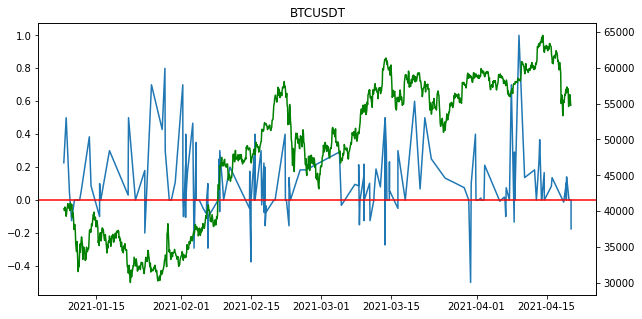

In [6]:
plt.rcParams['figure.figsize'] = [10, 5]
ts = df["Close"].astype(float) #.pct_change()

fig, ax1 = plt.subplots()
ax1.plot(scores)
plt.axhline(y=0, color='r', linestyle='-')
# ax1.plot(ts)
ax2 = ax1.twinx()
ax2.plot(ts, color='g')

plt.title(asset)

In [ ]:
# the rest of the notebook will work on all asset data

In [ ]:
all_tickers = Counter([tick for doc in docs for tick in doc._.tickers])
all_tickers.most_common(10)